In [81]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


# Define Constants

In [82]:
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


base_path = "/root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1/garbage_classification/"

categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


In [83]:
filenames = []
clss = []
for i in categories:
    files = os.listdir(f"{base_path}/{categories[i]}")
    for file in files:
        clss.append(categories[i])
        filenames.append(f"{base_path}/{categories[i]}/{file}")

df = pd.DataFrame({'filename':filenames,'category':clss})

df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [84]:
df.head()

,filename,category
0,/root/.cache/kagglehub/datasets/mostafaabla/ga...,green-glass
1,/root/.cache/kagglehub/datasets/mostafaabla/ga...,clothes
2,/root/.cache/kagglehub/datasets/mostafaabla/ga...,clothes
3,/root/.cache/kagglehub/datasets/mostafaabla/ga...,clothes
4,/root/.cache/kagglehub/datasets/mostafaabla/ga...,shoes


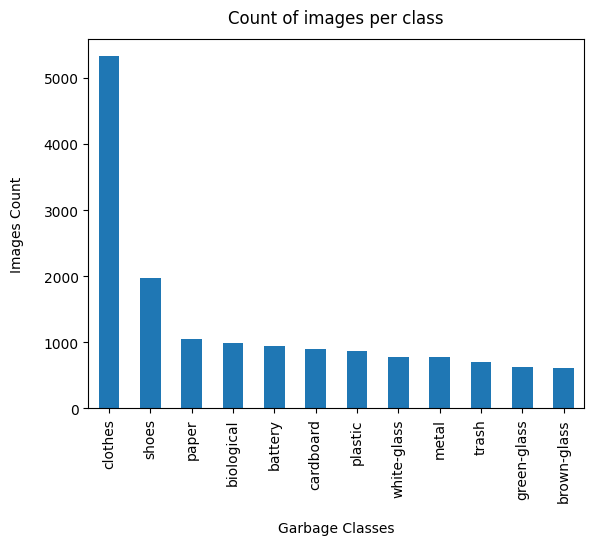

In [85]:
df_visualization = df.copy()
df["category"] = df["category"].replace(categories)

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [86]:
df["category"] = df["category"].replace(categories)

train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1551 validate size =  1551 test size =  1552


In [89]:
batch_size=64

train_datagen = ImageDataGenerator(
    preprocessing_function = xception.preprocess_input,
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [90]:
validation_datagen = ImageDataGenerator(
    preprocessing_function = xception.preprocess_input
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


In [91]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
import keras.applications.xception as xception

xception_layer = xception.Xception(
    include_top = False,
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
    weights = 'imagenet'
)
xception_layer.trainable = False


model = Sequential()
model.add(xception_layer)
model.add(GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 12)                  │          24,588 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,886,068 (79.67 MB)

 Trainable params: 24,588 (96.05 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [92]:
early_stop = EarlyStopping(
    patience = 2,
    verbose = 1,
    monitor='val_categorical_accuracy',
    mode='max',
    min_delta=0.001,
    restore_best_weights = True
)

callbacks = [early_stop]

print('call back defined!')

call back defined!


In [93]:
EPOCHS = 20
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - categorical_accuracy: 0.6681 - loss: 1.1473 - val_categorical_accuracy: 0.9056 - val_loss: 0.3423
Epoch 2/20
  1/193 ━━━━━━━━━━━━━━━━━━━━ 1:42 534ms/step - categorical_accuracy: 0.9531 - loss: 0.3208

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - categorical_accuracy: 0.9531 - loss: 0.3208 - val_categorical_accuracy: 0.9056 - val_loss: 0.3410
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - categorical_accuracy: 0.8927 - loss: 0.3739 - val_categorical_accuracy: 0.9219 - val_loss: 0.2629
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - categorical_accuracy: 0.9219 - loss: 0.2961 - val_categorical_accuracy: 0.9206 - val_loss: 0.2619
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - categorical_accuracy: 0.9131 - loss: 0.3031 - val_categorical_accuracy: 0.9284 - val_loss: 0.2360
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - categorical_accuracy: 0.9375 - loss: 0.2024 - val_categorical_accuracy: 0.9297 - val_loss: 0.2348
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - categorical_accuracy: 0.9206 - loss: 0.2670 - val_categorical_accuracy: 0.9342 - val_loss: 0.2136
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - categorical_accuracy: 0.8438 - lo

In [95]:
model.save("model.h5")

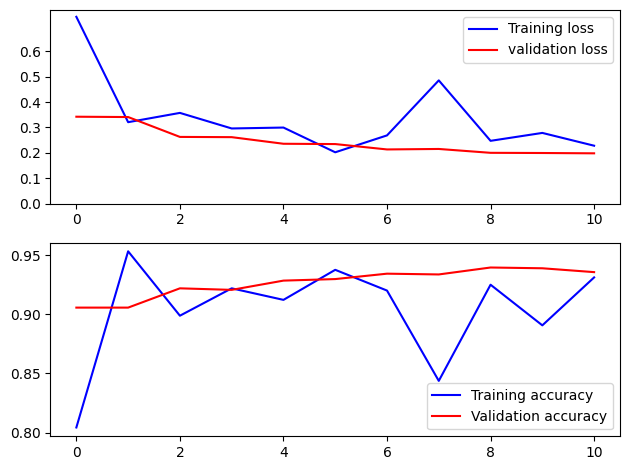

In [96]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [109]:
test_datagen = ImageDataGenerator(
        preprocessing_function = xception.preprocess_input,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

Found 1552 validated image filenames belonging to 12 classes.


In [110]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate(test_generator)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ')

   7/1552 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - categorical_accuracy: 1.0000 - loss: 0.0215

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1552/1552 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - categorical_accuracy: 0.9327 - loss: 0.2003
accuracy on test set =  93.88 % 


In [111]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [112]:
preds = model.predict(test_generator, nb_samples)

preds = preds.argmax(1)

preds = [gen_label_map[item] for item in preds]
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

1552/1552 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step
              precision    recall  f1-score   support

     battery       0.97      0.97      0.97       102
  biological       0.97      0.99      0.98       101
 brown-glass       0.90      0.85      0.87        61
   cardboard       0.95      0.85      0.90        96
     clothes       0.99      0.99      0.99       533
 green-glass       0.89      0.84      0.86        57
       metal       0.77      0.96      0.85        79
       paper       0.89      0.91      0.90       111
     plastic       0.83      0.75      0.79        93
       shoes       0.96      0.99      0.98       167
       trash       0.94      0.93      0.94        72
 white-glass       0.91      0.84      0.87        80

    accuracy                           0.94      1552
   macro avg       0.91      0.91      0.91      1552
weighted avg       0.94      0.94      0.94      1552

